<a href="https://colab.research.google.com/github/Prakhar314/COL764-Project/blob/main/pointwise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install Dependencies

In [1]:
!pip install tensorflow-addons transformers

     |████████████████████████████████| 1.1 MB 5.1 MB/s 
     |████████████████████████████████| 3.1 MB 33.8 MB/s 
     |████████████████████████████████| 59 kB 6.5 MB/s 
     |████████████████████████████████| 3.3 MB 37.7 MB/s 
     |████████████████████████████████| 895 kB 46.3 MB/s 
     |████████████████████████████████| 596 kB 48.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


### Load Data

#### Import libraries

In [2]:
import gc
import random
import os

import pandas as pd
import numpy as np
from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertTokenizer, TFBertModel, BertConfig
import tensorflow as tf
import tensorflow_addons as tfa

In [3]:
random.seed(0)
np.random.seed(0)
tf.random.set_seed(0)

#### Attach drive and unpack

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
# !rm /content/gdrive/MyDrive/col764/pointwise_best_model.h5

In [6]:
!tar -xf /content/gdrive/MyDrive/col764/collectionandqueries.tar.gz

In [7]:
!tar -xf /content/gdrive/MyDrive/col764/top1000.dev.tar.gz

In [8]:
!ls -alh

total 5.4G
drwxr-xr-x 1 root    root    4.0K Nov 21 14:14 .
drwxr-xr-x 1 root    root    4.0K Nov 21 14:09 ..
-rwxrwxrwx 1    1000    1000 2.9G Nov 13  2018 collection.tsv
drwxr-xr-x 4 root    root    4.0K Nov 18 14:35 .config
drwx------ 5 root    root    4.0K Nov 21 14:13 gdrive
-rwxrwxrwx 1    1000    1000 140K Jan 22  2019 qrels.dev.small.tsv
-rwxrwxrwx 1    1000    1000  11M Nov 28  2018 qrels.train.tsv
-rw-rw-r-- 1    1000    1000 284K May  2  2019 queries.dev.small.tsv
-rwxrwxrwx 1    1000    1000 4.3M Nov 13  2018 queries.dev.tsv
-rw-rw-r-- 1    1000    1000 275K May  2  2019 queries.eval.small.tsv
-rwxrwxrwx 1    1000    1000 4.3M Nov 13  2018 queries.eval.tsv
-rwxrwxrwx 1    1000    1000  34M Nov 13  2018 queries.train.tsv
drwxr-xr-x 1 root    root    4.0K Nov 18 14:36 sample_data
-rwxrwx--- 1 8045835 1049089 2.5G Jul 17  2019 top1000.dev


In [9]:
!wget https://msmarco.blob.core.windows.net/msmarcoranking/qrels.dev.tsv

--2021-11-21 14:15:44--  https://msmarco.blob.core.windows.net/msmarcoranking/qrels.dev.tsv
Resolving msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)... 20.150.34.4
Connecting to msmarco.blob.core.windows.net (msmarco.blob.core.windows.net)|20.150.34.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1201626 (1.1M) [text/tab-separated-values]
Saving to: ‘qrels.dev.tsv’

qrels.dev.tsv       100%[===================>]   1.15M  3.71MB/s    in 0.3s    

2021-11-21 14:15:46 (3.71 MB/s) - ‘qrels.dev.tsv’ saved [1201626/1201626]



#### Read data

In [10]:
root_dir = "/content/gdrive/MyDrive/col764/"

In [11]:
qrels = pd.read_csv('qrels.dev.tsv',sep='\t',header=None)

In [12]:
qrels.head(5)

,0,1,2,3
0,1102432,0,2026790,1
1,1102431,0,7066866,1
2,1102431,0,7066867,1
3,1090282,0,7066900,1
4,39449,0,7066905,1


In [13]:
top1000 = pd.read_csv('top1000.dev',sep='\t',header=None)
top1000

,0,1,2,3
0,188714,1000052,foods and supplements to lower blood sugar,Watch portion sizes: ■ Even healthy foods will...
1,1082792,1000084,what does the golgi apparatus do to the protei...,"Start studying Bonding, Carbs, Proteins, Lipid..."
2,995526,1000094,where is the federal penitentiary in ind,It takes THOUSANDS of Macy's associates to bri...
3,199776,1000115,health benefits of eating vegetarian,The good news is that you will discover what g...
4,660957,1000115,what foods are good if you have gout?,The good news is that you will discover what g...
...,...,...,...,...
6668962,679360,999933,what is a corporate bylaws,Corporate Records for Nonprofit Corporations. ...
6668963,36388,999956,average family savings account,When it comes to average retirement savings st...
6668964,43781,999956,average savings per age group,When it comes to average retirement savings st...
6668965,28442,999956,at what age does the average person retire,When it comes to average retirement savings st...


In [14]:
top1000 = top1000.sort_values(by=0).reset_index(drop=True)
top1000

,0,1,2,3
0,2,2700543,Androgen receptor define,Structure-function of the glucagon receptor fa...
1,2,2726978,Androgen receptor define,"In pharmacology, an antagonist binds to the re..."
2,2,2726974,Androgen receptor define,A drug antagonist is any drug that binds with ...
3,2,3046559,Androgen receptor define,A neurotransmitter receptor located in the pre...
4,2,1817960,Androgen receptor define,Effect of Beta2 Receptor Activation on Smooth ...
...,...,...,...,...
6668962,1102400,991048,why do bears hibernate,Hibernate mode uses the hiberfil.sys file to s...
6668963,1102400,5714166,why do bears hibernate,Black Bear. Though rarely seen by most New Yor...
6668964,1102400,7225717,why do bears hibernate,"The gummy bears grew in all of the. liquids, e..."
6668965,1102400,260344,why do bears hibernate,"In Asia, a large tiger might sometimes kill an..."


Distribution over tokens

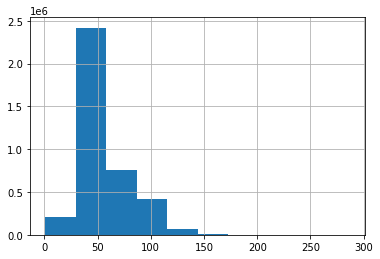

In [15]:
pd.DataFrame(top1000[3].unique()).apply(lambda x:len(x[0].split()),axis=1).hist()

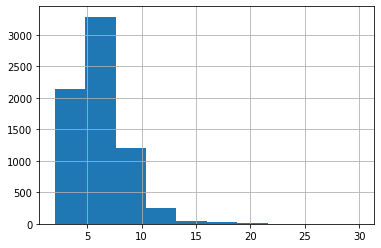

In [16]:
pd.DataFrame(top1000[2].unique()).apply(lambda x:len(x[0].split()),axis=1).hist()

### Preprocessing

Set train set size (number of query passage pairs)

In [ ]:
bert_model_name = 'bert-base-uncased'
passage_per_query = 50
num_queries = 100

In [ ]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
tokenizer.save_pretrained('./bert-tokenizer/')

('./bert-tokenizer/tokenizer_config.json',
 './bert-tokenizer/special_tokens_map.json',
 './bert-tokenizer/vocab.txt',
 './bert-tokenizer/added_tokens.json')

In [ ]:
!tar -zcvf bert-tokenizer.tar.gz bert-tokenizer

bert-tokenizer/
bert-tokenizer/tokenizer_config.json
bert-tokenizer/vocab.txt
bert-tokenizer/special_tokens_map.json


In [ ]:
qrels = qrels[[0,2]].rename(columns={0: 0, 2: 1})

In [ ]:
qrels['y']=1
qrels

,0,1,y
0,1102432,2026790,1
1,1102431,7066866,1
2,1102431,7066867,1
3,1090282,7066900,1
4,39449,7066905,1
...,...,...,...
59268,150337,8009410,1
59269,22241,8009429,1
59270,129177,8009442,1
59271,190655,3576091,1


Train Test Split

In [ ]:
qrels = qrels[qrels[0].isin(top1000[0].unique()[:num_queries])]

In [ ]:
split = np.random.choice(qrels[0].unique(),qrels.shape[0]//5)
train_queries = qrels[~qrels[0].isin(split)]
test_queries = qrels[qrels[0].isin(split)]

In [ ]:
assert not train_queries[0].isin(test_queries[0]).any()

Add labels

In [ ]:
def generateTable(queries):
  # Add labels
  df = pd.merge(top1000, queries,  how='left', left_on=[0,1], right_on = [0,1]).fillna(0)
  # drop queries not in set
  df = df[df[0].isin(queries[0])][[2,3,'y']]
  # positive samples
  df_p = df[df['y']==1].reset_index(drop=True)
  # negative samples
  df_n = df[(df[2].isin(df_p[2])) & (df['y']==0)]
  # sample
  df_n = df_n.groupby(2).sample(n=passage_per_query,replace=True).drop_duplicates().reset_index(drop=True)
  # append and shuffle
  df = df_p.append(df_n, ignore_index=True).sample(frac=1).reset_index(drop=True)
  return df


In [ ]:
train_set = generateTable(train_queries)
test_set = generateTable(test_queries)

In [ ]:
train_set

,2,3,y
0,an increase of adh causes the kidneys to _____...,Dark yellow urine is a sign of dehydration. Yo...,0.0
1,all of the following were created by the first...,John Hanson was the first president of the Con...,0.0
2,actress who plays alice on the magicians,Princess Alice died peacefully in her sleep at...,0.0
3,array definition computer,A single value in a JavaScript array is called...,0.0
4,amp definition,"See, the default power adapter that comes with...",0.0
...,...,...,...
3566,are corn snakes poisonous,Corn is a common staple of cultural diets all ...,0.0
3567,accelerated cml symptoms,Report Abuse. We think that ANY skydive is a g...,0.0
3568,airport code mont tremblant,"1 Enter the Distance To city, village, town, a...",0.0
3569,academic cheating definition,(Definition of “cellophane” from the Cambridge...,0.0


There shouldn't be any overlap in queries

In [ ]:
assert not train_set[2].isin(test_set[2]).any()

In [ ]:
# from sklearn.model_selection import train_test_split
# train_set,test_set = train_test_split(train_set,test_size=0.2)

In [ ]:
# batch_size = 128
# def generateSamples(df):
#   for i,row in df.iterrows():
#     q = tokenizer(row[2], return_tensors="tf",padding="max_length",max_length=q_trunc,truncation=True)
#     p = tokenizer(row[3], return_tensors="tf",padding="max_length",max_length=p_trunc,truncation=True)
#     X={}
#     for id in ['input_ids','token_type_ids','attention_mask']:
#       X[id] = tf.concat([q[id],p[id][:,1:]],1)
#     yield X,[row['y']]
# type_dict = {id:tf.int32 for id in ['input_ids','token_type_ids','attention_mask']}
# train_ds = tf.data.Dataset.from_generator(lambda :generateSamples(train_set),(type_dict,tf.int32))
# train_ds = train_ds.batch(batch_size).prefetch(1)
# test_ds = tf.data.Dataset.from_generator(lambda :generateSamples(test_set),(type_dict,tf.int32))
# test_ds = test_ds.batch(batch_size).prefetch(1)

##### Tokenize

Truncation Limits

In [ ]:
q_trunc = 64
p_trunc = 449
assert q_trunc+p_trunc-1==512

Create training set

In [ ]:
def generateSet(df):
  # tokenize
  q = tokenizer(df[2].values.tolist(), return_tensors="tf",padding="max_length",max_length=q_trunc,truncation=True)
  p = tokenizer(df[3].values.tolist(), return_tensors="tf",padding="max_length",max_length=p_trunc,truncation=True)
  X=[]
  # labels
  y = df['y']
  for id in ['input_ids','token_type_ids','attention_mask']:
    X.append(tf.concat([q[id],p[id][:,1:]],1))
  # delete unwanted variables
  q = None
  p = None
  gc.collect()
  return X,y

In [ ]:
X_train,y_train = generateSet(train_set)
X_test,y_test = generateSet(test_set)

#### Setup Tensorflow

Setup TPU

In [ ]:
# #Get a handle to the attached TPU. On GCP it will be the CloudTPU itself
# resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])
# #Connect to the TPU handle and initialise it
# tf.config.experimental_connect_to_cluster(resolver)
# tf.tpu.experimental.initialize_tpu_system(resolver)
# strategy = tf.distribute.experimental.TPUStrategy(resolver)

In [ ]:
tf.config.run_functions_eagerly(False)

### Create Model

Batch size: 128 on TPU, 8 on GPU

In [ ]:
num_epochs = 2
batch_size = 8
num_train_steps = X_train[0].shape[0]//batch_size*num_epochs

A model with three inputs:
- Input IDs
- Token Type IDs
- Attention Masks
These are from tokenizer.

Fed to BERT, from which the [CLS] vector is taken, and fed into a dense layer with one output after sigmoid.

In [ ]:
def create_inputs(num_nodes,name):
  layers = []
  for layer_name in ['input_ids','token_type_ids','attention_mask']:
    layers.append(tf.keras.layers.Input(shape=(num_nodes,),dtype=tf.int32,name=layer_name))
  return layers

def create_model(output_bias=None):
    if output_bias is not None:
      output_bias = tf.keras.initializers.Constant(output_bias)
    config = BertConfig(hidden_dropout_prob=0.1)
    bert = TFBertModel.from_pretrained(bert_model_name,config=config)
    bert.save_pretrained('./bert-model/')
    for layer in bert.layers[:]:
      if isinstance(layer, transformers.models.bert.modeling_tf_bert.TFBertMainLayer):
        layer.embeddings.trainable=False
        layer.pooler.trainable=False
        for idx, layer in enumerate(layer.encoder.layer):
            # print(layer)
            # freeze first 10
            if idx in range(10):
                layer.trainable = False
      else:
        layer.trainable = False
              
    input_layer = create_inputs(512,'pair')
    bert_out = bert(input_layer).last_hidden_state
    cls = tf.keras.layers.Lambda(lambda x:x[:,0,:])(bert_out)
    # print(avg_q.shape)
    output = tf.keras.layers.Dense(1, activation="sigmoid",bias_initializer=output_bias)(cls)
    model = tf.keras.models.Model(inputs=input_layer, outputs=[output])
    opt,schedule = transformers.create_optimizer(num_train_steps=num_train_steps,init_lr=3e-5,adam_beta1=0.9,adam_beta2=0.999,weight_decay_rate=0.01,num_warmup_steps=num_train_steps//10)
    # opt = tfa.optimizers.RectifiedAdam()
    model.compile(optimizer=opt,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(),
                       tf.keras.metrics.AUC(curve="ROC")])
    model.summary()
    return model

Save on best validation loss

In [ ]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(root_dir + "pointwise_best_model.h5", monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min', save_freq='epoch')

Check GPU

In [ ]:
tf.test.gpu_device_name()

'/device:GPU:0'

Free memory

In [ ]:
gc.collect()

150

Hide warnings

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
tf.get_logger().setLevel('WARNING')

Biases, and class weights

In [ ]:
total = len(train_set['y'])
pos = train_set['y'].sum()
neg = total-pos
initial_bias = np.log([pos/neg])

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}
# class_weight={0:1,1:1}

#### Train

In [ ]:
def createAndRun():
  model = None
  if initial_bias:
    print("Bias",initial_bias)
    model = create_model(initial_bias)
  else:
    model = create_model()
  gc.collect()
  print("Class weight",class_weight)
  # model.fit(x=train_ds, epochs=4, verbose=1, validation_data=test_ds, callbacks=[checkpoint])
  history = model.fit(x=X_train, y=y_train, batch_size=batch_size, epochs=num_epochs, verbose=1, validation_data=(X_test,y_test), use_multiprocessing=False, callbacks=[checkpoint],class_weight=class_weight)
  model.save_weights('final_model.h5')
  return model,history

def cpu():
  return createAndRun()

def gpu():
  with tf.device('/device:GPU:0'):
    return createAndRun()

def tpu():
  with strategy.scope():
    return createAndRun()

In [ ]:
# model,history = cpu()

In [ ]:
model,history = gpu()

Bias [-3.82835531]


Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 token_type_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'token_type_ids[0][0]',     

In [ ]:
# model,history = tpu()

In [ ]:
!tar -zcvf bert-model.tar.gz bert-model

bert-model/
bert-model/tf_model.h5
bert-model/config.json


In [ ]:
!ls -alh top1000.dev qrels.dev.tsv

-rw-r--r-- 1 root    root    1.2M Nov 28  2018 qrels.dev.tsv
-rwxrwx--- 1 8045835 1049089 2.5G Jul 17  2019 top1000.dev


In [ ]:
pd.DataFrame({
    'embedding':[True,False,False,False],
    'batch':[128,128,128,128],
    'time':[327,225,180,254],
    'loss':[0.67241,0.66957,0.22111,0.5409],
    'auc':[0.5674,0.5798,0.5055,0.8734],
    'acc':[0.5811,0.5958,0.9479,0.7318],
    'frozen':[10,10,12,8]
              })

,embedding,batch,time,loss,auc,acc,frozen
0,True,128,327,0.67241,0.5674,0.5811,10
1,False,128,225,0.66957,0.5798,0.5958,10
2,False,128,180,0.22111,0.5055,0.9479,12
3,False,128,254,0.54090,0.8734,0.7318,8
